<a href="https://colab.research.google.com/github/christpaul94/MastersThesis_PaulChrist/blob/main/TrappedAtomsSimulation_HarmonicPotential.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# TrappedAtomsSimulation_HarmonicPotential

Author: Paul Christ

Date: 04.11.2025


In [1]:
!pip install -qq git+https://github.com/christpaul94/MastersThesis_PaulChrist.git

  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 552.2/552.2 kB 10.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 118.5/118.5 kB 11.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 293.6/293.6 kB 24.3 MB/s eta 0:00:00


In [2]:
# Import
from TrappedAtomsSimulation.initialization import initialize_one_temp_gaussian_state, initialize_two_temp_gaussian_state
from TrappedAtomsSimulation.force_calculation import calculate_interaction_strength
from TrappedAtomsSimulation.force_calculation import pair_keops_fp
from TrappedAtomsSimulation.integrators import run_verlet_simulation_HO, solve_harmonic_analytical
from TrappedAtomsSimulation.plot_utils import plot_energy_and_error, plot_thermalization

import torch

[KeOps] Compiling cuda jit compiler engine ... OK
[pyKeOps] Compiling nvrtc binder for python ... OK


In [3]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
dtype = torch.float32

## Trap

In [4]:
trap_frequencies_Hz = (1000.0, 1050.0, 1200.0)

### One group

In [5]:
# eine gruppe

--- Skalierung basierend auf T = 1.00e-06 K ---
Längenskala L0: 1.56e-06 m, Energieskala E0: 1.38e-29 J, Zeitskala T0: 1.59e-04 s
Initialisiere 1000 Teilchen bei T = 1.00e-06 K
--- Initialisierung abgeschlossen ---



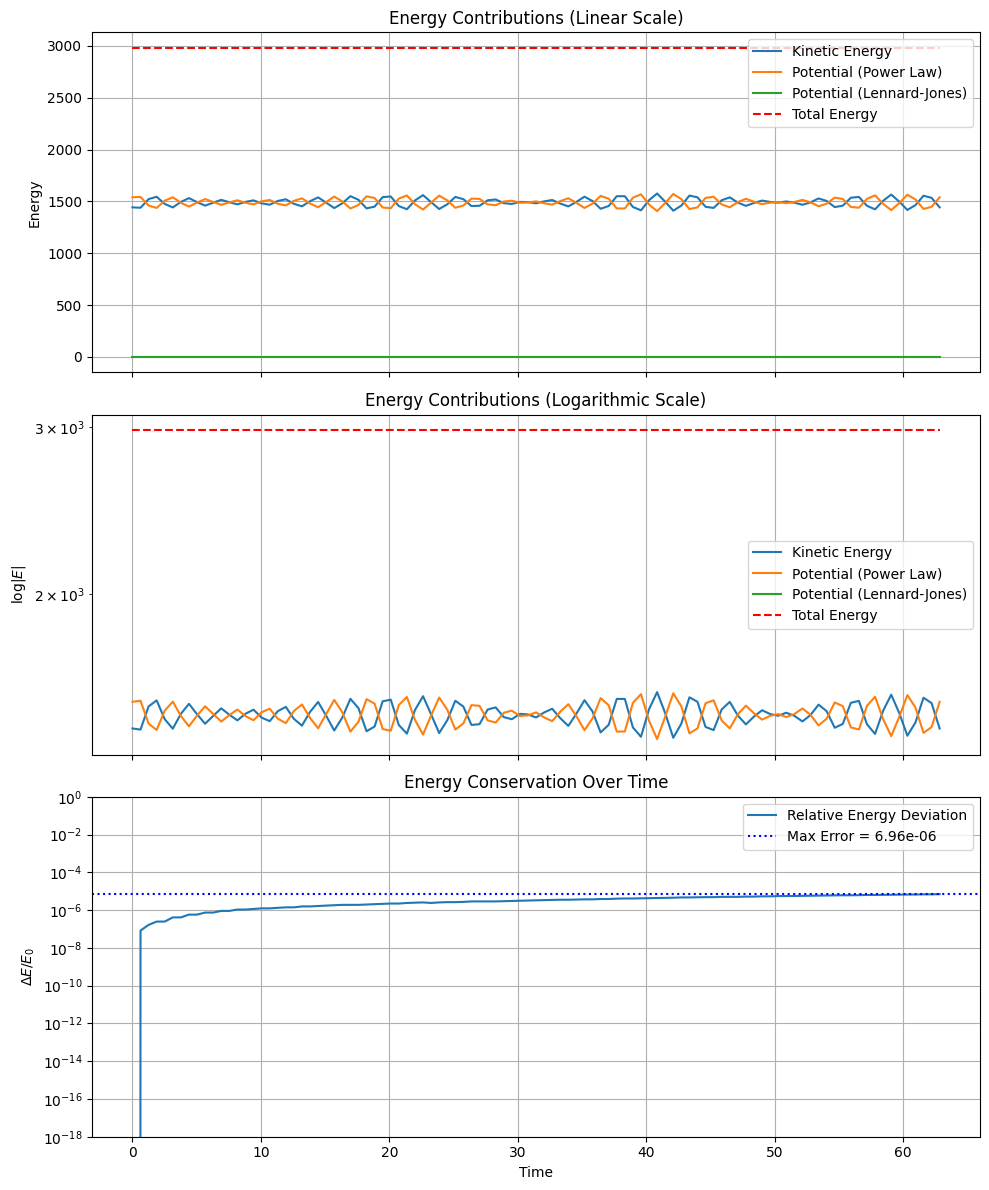

tensor(6.9612e-06, device='cuda:0')

In [6]:
# exakte lösung
simulation_time_s = 0.01
timestep_s = 1e-4
substeps = 10
n_particles = 1000
T = 1e-6

initial_state_params = initialize_one_temp_gaussian_state(
    n_particles=n_particles,
    temp_k=T,
    omega_phys_hz=trap_frequencies_Hz,
    t_end_s=simulation_time_s,
    dt_s=timestep_s,
    r0_phys=None,  # <-- Wichtig: Keine WW
    C_phys=None,   # <-- Wichtig: Keine WW
    precision=dtype,
    device=device
)

integrator_config = {
    "pair_force_func": None, # (wird ignoriert)
    "substeps": 1             # (wird ignoriert)
}

simulation_input_args = {**initial_state_params, **integrator_config}


# ---  Simulation starten ---

results_analytical = solve_harmonic_analytical(**simulation_input_args)
plot_energy_and_error(results_analytical['times'], results_analytical['kinetic_energy'],results_analytical['potential_energy_harmonic'],results_analytical['potential_energy_pair'])


In [10]:
# eine gruppe
simulation_time_s = 0.01
timestep_s = 1e-4
substeps = 100
n_particles = 1000
T = 1e-6

r0_phys,C_phys = calculate_interaction_strength(10)
print((r0_phys,C_phys))


initial_state_params = initialize_one_temp_gaussian_state(
    n_particles=n_particles,
    temp_k=T,
    omega_phys_hz=trap_frequencies_Hz,
    t_end_s=simulation_time_s,
    dt_s=timestep_s,
    r0_phys=r0_phys,
    C_phys=C_phys,
    precision=dtype,
    device=device
)

integrator_config = {
    "pair_force_func": pair_keops_fp,
    "substeps": substeps
}

simulation_input_args = {**initial_state_params, **integrator_config}

# --- Simulation starten ---
simulation_results = run_verlet_simulation_HO(**simulation_input_args)
plot_energy_and_error(simulation_results['times'], simulation_results['kinetic_energy'],simulation_results['potential_energy_harmonic'],simulation_results['potential_energy_pair'])

(5.237793946e-08, 2.2411966953567952e-30)
--- Skalierung basierend auf T = 1.00e-06 K ---
Längenskala L0: 1.56e-06 m, Energieskala E0: 1.38e-29 J, Zeitskala T0: 1.59e-04 s
Initialisiere 1000 Teilchen bei T = 1.00e-06 K
--- Initialisierung abgeschlossen ---

Integration 6% | Time: 0 min 18 s

KeyboardInterrupt: 

### Two groups

--- Skalierung basierend auf Referenztemperatur T_ref = 1.00e-06 K ---
Längenskala L0: 1.56e-06 m, Energieskala E0: 1.38e-29 J, Zeitskala T0: 1.59e-04 s
Initialisiere Gruppe mit 1111 Teilchen bei T = 1.00e-06 K
Initialisiere Gruppe mit 1111 Teilchen bei T = 2.00e-06 K
Skaliere Interaktionsparameter...
--- Zwei-Temperatur-Initialisierung abgeschlossen ---

Integration 100% | Time: 0 min 0 s

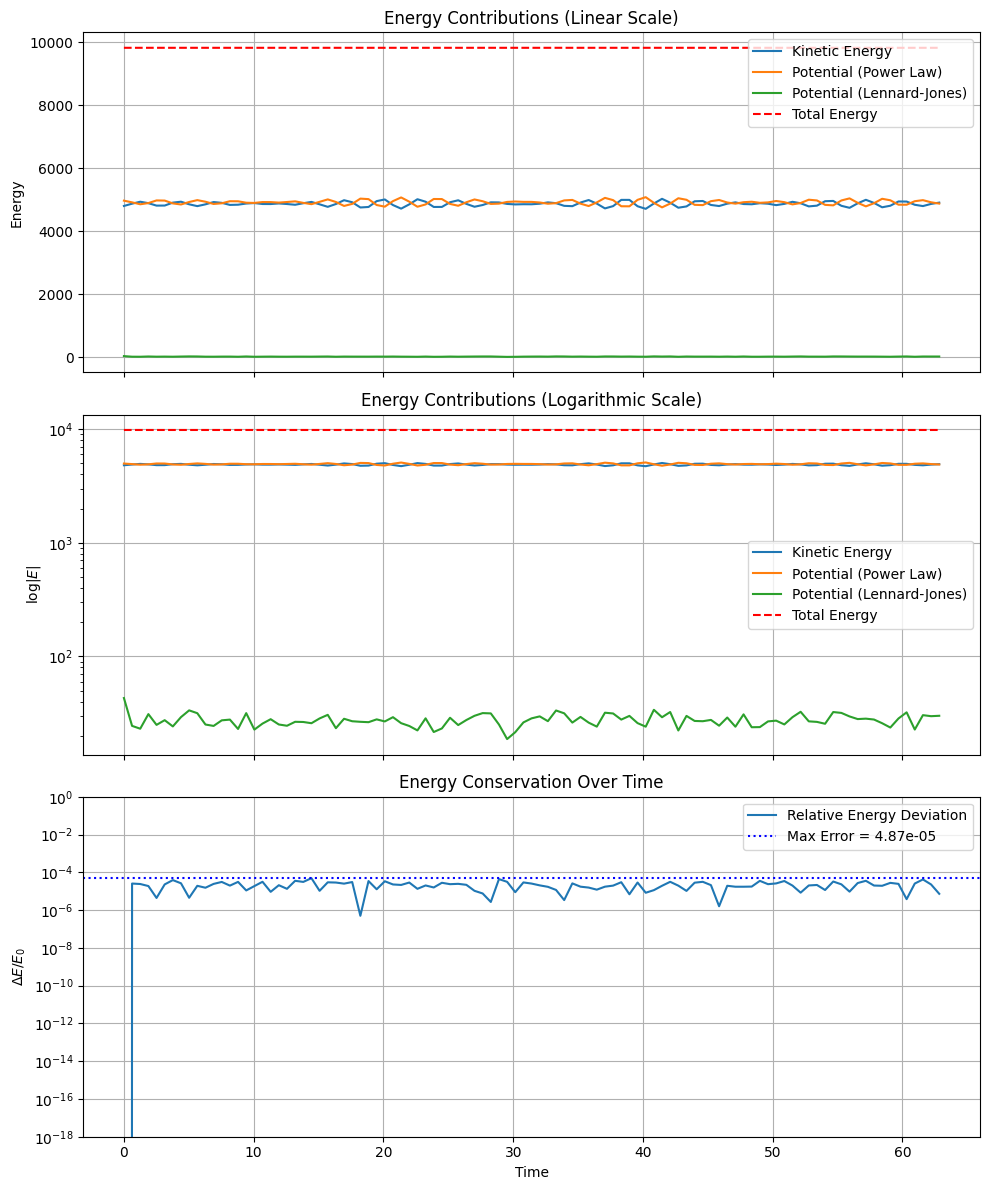

/tmp/ipython-input-343847033.py:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  T0_s=torch.tensor(initial_state_params['T0_s']) # T0 als Tensor übergeben


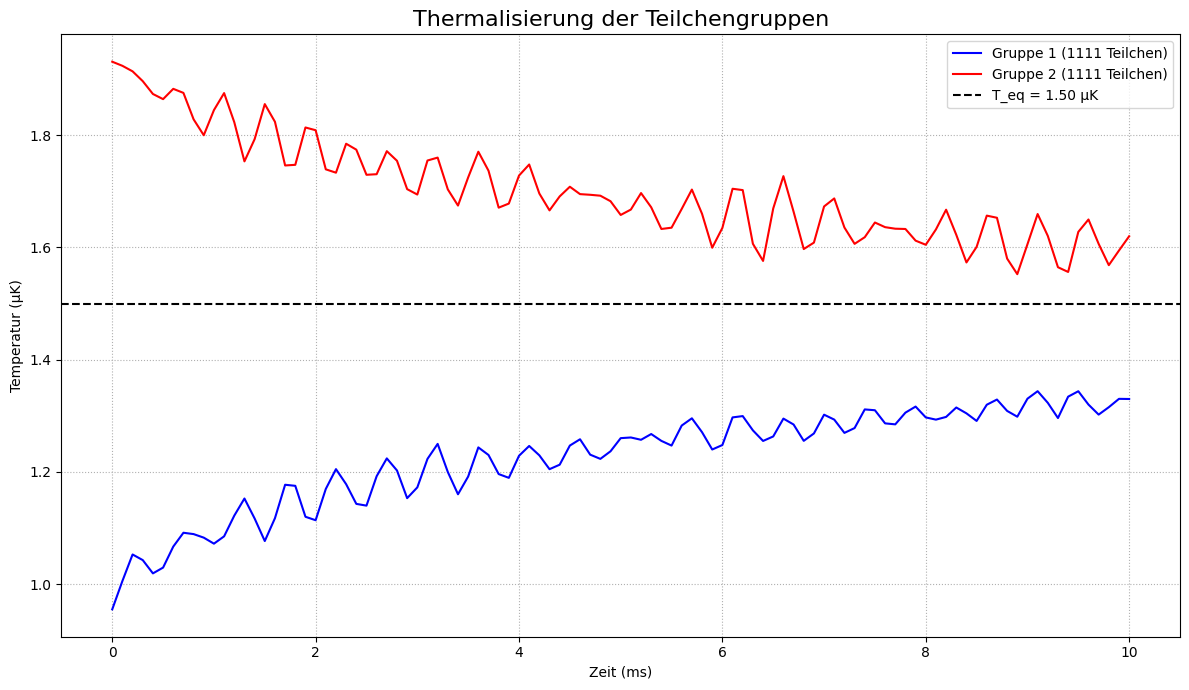

In [11]:

n_groups = (1111, 1111) # 2000 kalte, 1000 heiße Teilchen
temp_groups = (1e-6, 2e-6)

initial_state_params = initialize_two_temp_gaussian_state(
    n_particles_groups = n_groups,
    temp_k_groups = temp_groups ,
    omega_phys_hz=trap_frequencies_Hz,
    t_end_s=simulation_time_s,
    dt_s=timestep_s,
    r0_phys=r0_phys,
    C_phys=C_phys*10,
    precision=dtype,
    device=device
)


integrator_config = {
    "pair_force_func": pair_keops_fp,
    "substeps": substeps
}

simulation_input_args = {**initial_state_params, **integrator_config}


# --- Simulation starten ---
simulation_results = run_verlet_simulation_HO(**simulation_input_args)
plot_energy_and_error(simulation_results['times'], simulation_results['kinetic_energy'],simulation_results['potential_energy_harmonic'],simulation_results['potential_energy_pair'])
plot_thermalization(
        results=simulation_results,
        n_groups=n_groups,
        temp_groups=temp_groups,
        T0_s=torch.tensor(initial_state_params['T0_s']) # T0 als Tensor übergeben
    )